## Water Rocket Simulator

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
# Function to conversion to Internation Units and vice-versa:
# Use: toUnit[to unit][from unit](value)

toUnit = {}
toUnit ['m']   = {'mm' :lambda u: u*1E-3,
                  'ft' :lambda u: u*0.3048}
toUnit ['mm']  = {'m'  :lambda u: u*1E3}

toUnit ['m/s'] = {'miles/h':lambda u: u*0.44704}

toUnit ['ms']  = {'s'  :lambda u: u*1E3}

toUnit ['l']   = {'m3' :lambda u: u*1E3,    
                  'ml' :lambda u: u*1E3}
toUnit ['ml']  = {'l'  :lambda u: u*1E3,    
                  'm3' :lambda u: u*1E+6}
toUnit ['m3']  = {'l'  :lambda u: u*1E-3,   
                  'ml' :lambda u: u*1E-6}

toUnit ['kg']  = {'g'  :lambda u: u*1E-3}
toUnit ['g']   = {'kg' :lambda u: u*1E3}

toUnit ['Pa']  = {'psi':lambda u: u*6_894.8}
toUnit ['psi'] = {'Pa' :lambda u: u/6_894.8}

toUnit ['K']  =  {'C'  :lambda u: 273+u}
toUnit ['C']  =  {'K'  :lambda u: u-273}

toUnit ['Gs'] =  {'m/s2': lambda u: u/9.81}

### Default Integration Parameters:
$\text{δt}$ = 0.001 (s) : Time interval for intergration<BR>
t_max = 10 (s) : Max flight fime for integration
    
### Constants:
$g$ = 9.81 m/s^2: gravitational acceleration<BR>
γ = 1.4 : adiabatic constant for air<BR>
ρ_water = 1000 kg/m^3 : density of water<BR>
R = 8.3145 J/(mol K) : Ideal gas constant<BR>
Air average molar mass = 28.9 g/mol<BR>
    
### Conversion factors:
1 psi = 6894.8 Pa



In [3]:
# Uncertainties:
uncertainty_altimeter_z =     5
uncertainty_altimeter_t =     0.1
uncertainty_altimeter_speed = 5
uncertainty_manometer_p =     2

# Constants:
g = 9.81
γ = 1.4
ρ_water = 1_000
R = 8.3145
m_mol_air        = toUnit['kg']['g'](28.9)

# Integration interval:
δt = 0.001  
t_max = 10

In [4]:
def update_parameters (_v,_vol_air_initial,_vol_water,_p_air,_temp_air,_k_air_drag,_vol_rocket,_m_rocket,_temp_external,_p_atmospheric,_r_nozzle,_p_launch):
    
    _m_water = _vol_water * ρ_water
    _vol_air = _vol_rocket-_vol_water
       
    _m_air = (m_mol_air/R) * ((_p_air) * _vol_air/_temp_air)    
             
    # Water expeled equations: 
    if _vol_water > 0:
        _v_air = 0   # velocity of air leaving the nozzle
        _v_water_expelled = np.sqrt(2*_p_air/ρ_water)
        _vol_water_expelled = (np.pi*(_r_nozzle)**2) * _v_water_expelled * δt
        _m_water_expelled = _vol_water_expelled * ρ_water 
        _m_water -= _m_water_expelled
        _vol_water = _m_water/ρ_water
        _vol_air = _vol_rocket-_vol_water
        _p_air = _p_launch * (_vol_air_initial/_vol_air)**γ    
        
        # Air temperature changes due to the volume change:
        _temp_air = _temp_external* (_vol_air_initial/_vol_air)**(γ-1)
        
    # Density of air inside the rocket:
    _ρ_air = ((_p_air+_p_atmospheric) * m_mol_air / (_temp_air *R)) 

        
    # Air expelled equations:
    if _vol_water <= 0 and _p_air >0:
        _v_water = 0
        _v_air = 1.081*np.sqrt(_p_air/_ρ_air)
        _m_air_expelled = (np.pi*(_r_nozzle)**2) * _v_air * _ρ_air * δt
        _p_air = ((_m_air-_m_air_expelled)/_m_air)*_p_air
        _m_air -= _m_air_expelled
        # Temperature does not changes in adiabatic expansion when volume is the same
    
    # Total mass of rocket with water and compressed air:
    # OBS: The mass of air is only the extra air in order to avoid the need to calculate the hydrostatic force of air
    _m_total = _m_water + _m_rocket + _m_air   
        
    # Forces:    
    # gravity:
    _f_gravity = _m_total * (-g)
    
    # air drag:  
    if _v == 0:
        _f_air_drag = 0
    else:
        _f_air_drag = -_v/np.sqrt(_v**2) * _k_air_drag * _v**2
    
    # thrust:
    # thrust due to water being expeled:
    _f_thrust_water = 0
    if _vol_water > 0:
        _f_thrust_water = _m_water_expelled * _v_water_expelled /δt         
            
    # thrust due to air being expeled:
    _f_thrust_air = 0
    if (_vol_water <= 0) and (_p_air > 0):
        _f_thrust_air = _m_air_expelled * _v_air / δt
        
  
    
    # calculate the aceleration
    _a = (_f_gravity + _f_air_drag + _f_thrust_water + _f_thrust_air)/_m_total
    
    # calculate the new state of rocket (water mass, internal air pressure)
            
    return (_a,_vol_water,_p_air,_m_total,_temp_air,_m_air,_f_thrust_water,_f_thrust_air,_f_air_drag)

### Calculation of rocket trajectory and internal conditions:

```integration ()```<BR><BR>
<B>Launch parameters:</B>
<LI>r_nozzle=<I>float</I> (<FONT color="#FF0000">Nozzle radius in <B>mm</B></FONT>) Default: 5
<LI>p_launch=<I>float</I> (<FONT color="#FF0000">Launch pressure <B>psi</B></FONT>) Default: 40
<LI>vol_water_launch=<I>float</I> (<FONT color="#FF0000">Volume of Water <B>ml</B></FONT>) Default: 526
<LI>vol_rocket=<I>float</I> (<FONT color="#FF0000">Total volume of water <B>ml</B></FONT>) Default: 1500
<LI>m_rocket=<I>float</I> (<FONT color="#FF0000">Mass of rocket <B>g</B></FONT>) Default: 148
<LI>temp_external=<I>float</I> (<FONT color="#FF0000">External temperature <B><SUP>o</SUP>C</B></FONT>) Default: 22
<LI>p_atmospheric=<I>float</I> (<FONT color="#FF0000">Atmospheric pressure <B>Pa</B></FONT>) Default: 99036
<LI>Cd=<I>float</I> (<FONT color="#FF0000">Drag coeficient </FONT>) Default: 0.4
<LI>r_rocket=<I>float</I> (<FONT color="#FF0000">Rocket radius <B>mm</B></FONT>) Default: 45
<LI>z_initial=<I>float</I> (<FONT color="#FF0000">Initial height relative to landing height <B>m</B></FONT>) Default: 0
<LI>v_initial=<I>float</I> (<FONT color="#FF0000">Initial vertical speed <B>m/s</B></FONT>) Default: 0

<BR>
<B>Returns:</B><BR>
Nested dictionary:<BR>
<LI>experimental_condition<BR>
    {launch parameters}
<LI>trajectory_data<BR>
    {<BR>
    't_apoggee': float <I>(time to reach the Apoggee in s)</I>,<BR>
    'z_apoggee':float <I>(height of the Apoggee in m)</I>,<BR>
    'v_max':float <I>(max speed in m/s)</I>,<BR>
    't_water_ends':float <I>(time since launch water ends in s)</I>,<BR>
    't_air_ends':float <I>(time since launch that internal air pressure = external pressure in s)</I>,<BR>    
    'a_average_during_thrust':float <I>(average acceleration during thrust in m/s^2)</I>,<BR>
    't_thrust':float <I>(total thrust time in s)</I>,<BR>
    'T':numpy array (float) <I>time (s) in each row</I>,<BR>
    'Z':numpy array (float)<I>height (m) in each row</I>,<BR>
    'V':numpy array (float)<I>speed (m/s) in each row</I>,<BR>
    'A':numpy array (float)<I>acceleration (m/s^2) in each row</I>,<BR>
    'VOL_WATER':numpy array (float)<I>water volume (m3) in each row</I>,<BR>
    'P':numpy array (float)<I>time (s) in each row</I>,<BR>
    'M_AIR':numpy array (float)<I>mass of extra air inside the rocket in a given time aligned with T (kg) in each row</I>,<BR>
    'F_THRUST_WATER':numpy array (float)<I>thrust force generated by expelled water in a given time aligned with T (N) in each row</I>,<BR>
    'F_THRUST_AIR':numpy array (float)<I>thrust force generated by expelled air in a given time aligned with T (N) in each row</I>,<BR>
    'F_AIR_DRAG':numpy array (float)<I>air drag force in a given time aligned with T (N) in each row</I>,<BR>
    'TEMP_AIR':numpy array (float)<I>internal air temperature in a given time aligned with T (K) in each row</I>,<BR>
    'TOTAL_ROCKET_MASS':numpy array (float)<I>total rocket mass in a given time aligned with T (kg) in each row</I>,<BR>
    }


In [5]:
def integration (**kwargs):
    
    # Default parameters:
    _experimental_condition_dic = dict()
    _experimental_condition_dic['z_initial']       = 0
    _experimental_condition_dic['v_initial']       = 0    
    _experimental_condition_dic['r_nozzle']        = toUnit['m']['mm'](5)
    _experimental_condition_dic['p_launch']        = toUnit['Pa']['psi'](40)
    _experimental_condition_dic['vol_water_launch']= toUnit['m3']['ml'](526)
    _experimental_condition_dic['vol_rocket']      = toUnit['m3']['ml'](1500)
    _experimental_condition_dic['m_rocket']        = toUnit['kg']['g'](148)
    _experimental_condition_dic['temp_external']   = toUnit['K']['C'](22)  
    _experimental_condition_dic['p_atmospheric']   = 99_036
    _experimental_condition_dic['Cd']              = 0.38     
    _experimental_condition_dic['r_rocket']        = toUnit['m']['mm'](45)
    
    # New parameters:
    if 'z_initial' in kwargs.keys():  _experimental_condition_dic['z_initial'] = kwargs['z_initial']
    if 'v_initial' in kwargs.keys():  _experimental_condition_dic['v_initial'] = kwargs['v_initial']        
    if 'r_nozzle'  in kwargs.keys():  _experimental_condition_dic['r_nozzle']  = toUnit['m']['mm'](kwargs['r_nozzle'])   # r_nozzle in mm
    if 'p_launch'  in kwargs.keys():  _experimental_condition_dic['p_launch']  = toUnit['Pa']['psi'](kwargs['p_launch']) # p_launch in psi    
    if 'vol_water_launch'  in kwargs.keys():  _experimental_condition_dic['vol_water_launch']  = toUnit['m3']['ml'](kwargs['vol_water_launch']) # vol_water_launch in ml
    if 'vol_rocket'        in kwargs.keys():  _experimental_condition_dic['vol_rocket']        = toUnit['m3']['ml'](kwargs['vol_rocket'])       # vol_rocket in ml
    if 'r_rocket'          in kwargs.keys():  _experimental_condition_dic['r_rocket']          = toUnit['m'] ['mm'](kwargs['r_rocket'])         # radius of bottle in mm used as body for the water rocket
    if 'm_rocket'          in kwargs.keys():  _experimental_condition_dic['m_rocket']          = toUnit['kg']['g'] (kwargs['m_rocket'])         # rocket mass in g
    if 'temp_external'     in kwargs.keys():  _experimental_condition_dic['temp_external']     = toUnit['K'] ['C'] (kwargs['temp_external'])    # External temperature in C 
    if 'p_atmospheric'     in kwargs.keys():  _experimental_condition_dic['_p_atmospheric']    = kwargs['p_atmospheric']                        # Atmospheric pressure in Pa
    if 'Cd'                in kwargs.keys():  _experimental_condition_dic['Cd']                = kwargs['Cd']
    
    # Initialize performance parameters
    _trajectory_data = dict()
    
    _trajectory_data['t_apoggee']     = np.nan
    _trajectory_data['z_apoggee']     = np.nan
    _trajectory_data['v_max']         = np.nan
    _trajectory_data['t_water_ends']  = np.nan   
    _trajectory_data['t_air_ends']    = np.nan       

    # Initialize the lists to execute the numerical integrals:
    _T = np.array([],float)
    _Z = np.array([],float)
    _V = np.array([],float)
    _A = np.array([],float)
    _VOL_WATER = np.array([],float)
    _P = np.array([],float) # Pressure inside the rocket (above external air)
    _M_AIR = np.array([],float) # Mass of air inside the rocket (total)
    _F_THRUST_WATER = np.array([],float)
    _F_THRUST_AIR   = np.array([],float)
    _F_AIR_DRAG     = np.array([],float)
    _TEMP_AIR = np.array([],float)
    
    ##########################################################################
    # INTEGRATION:
    # Initial conditions:   
    _t_                = 0     
    z_                = _experimental_condition_dic['z_initial']
    v_                = _experimental_condition_dic['v_initial']
    a_                = 0    
    temp_air_         = _experimental_condition_dic['temp_external'] 
    vol_water_        = _experimental_condition_dic['vol_water_launch']
    p_air_            = _experimental_condition_dic['p_launch']    
    _ρ_air_external   = _experimental_condition_dic['p_atmospheric'] * m_mol_air / (_experimental_condition_dic['temp_external']  *R)        
    _cross_section_rocket = np.pi*(_experimental_condition_dic['r_rocket'])**2
    _k_air_drag = 1/2 * _ρ_air_external * _experimental_condition_dic['Cd'] * _cross_section_rocket  
    _vol_air_initial  = _experimental_condition_dic['vol_rocket']-_experimental_condition_dic['vol_water_launch']
    
    
    (_a0,_vol_water0,_p_air0,_m_total0,_temp_air0,m_air_,f_thrust_water_,f_thrust_air_,f_air_drag_) = \
    update_parameters (v_,
                       _vol_air_initial,
                       _experimental_condition_dic['vol_water_launch'],
                       _experimental_condition_dic['p_launch'],
                       _experimental_condition_dic['temp_external'] ,
                       _k_air_drag,
                      _experimental_condition_dic['vol_rocket'],
                      _experimental_condition_dic['m_rocket'],
                      _experimental_condition_dic['temp_external'],
                      _experimental_condition_dic['p_atmospheric'],
                      _experimental_condition_dic['r_nozzle'],
                      _experimental_condition_dic['p_launch'])
          
    # Integration over t<=t_max:
    while _t_ <= t_max:
        z_prior       = z_
        v_prior       = v_
        vol_water_prior = vol_water_
        p_prior       = p_air_
        temp_air_prior = temp_air_

        _T              = np.append(_T,_t_)
        _Z              = np.append(_Z,z_)
        _V              = np.append(_V,v_)
        _A              = np.append(_A,a_)
        _VOL_WATER      = np.append(_VOL_WATER,vol_water_)
        _P              = np.append(_P,p_air_)
        _M_AIR          = np.append(_M_AIR,m_air_)
        _F_THRUST_WATER = np.append(_F_THRUST_WATER,f_thrust_water_)
        _F_THRUST_AIR   = np.append(_F_THRUST_AIR  ,f_thrust_air_)
        _F_AIR_DRAG     = np.append(_F_AIR_DRAG    ,f_air_drag_)
        _TEMP_AIR       = np.append(_TEMP_AIR,temp_air_)

        (a_,vol_water_,p_air_,_m_total,temp_air_,m_air_,f_thrust_water_,f_thrust_air_,f_air_drag_) = update_parameters (v_prior,
                                                                                                                        _vol_air_initial,
                                                                                                                        vol_water_prior,
                                                                                                                        p_prior,
                                                                                                                        temp_air_prior,
                                                                                                                       _k_air_drag,
                                                                                                                       _experimental_condition_dic['vol_rocket'],
                                                                                                                       _experimental_condition_dic['m_rocket'],
                                                                                                                       _experimental_condition_dic['temp_external'],
                                                                                                                       _experimental_condition_dic['p_atmospheric'],
                                                                                                                       _experimental_condition_dic['r_nozzle'],
                                                                                                                       _experimental_condition_dic['p_launch'])
        v_ = v_prior + a_ * δt
        z_ = z_prior + v_ * δt


        ################
        # Find trajectory parameters reported from ALTIMETER 2:

        # t_thrust: Time when thrust ended (p_=0)

        # Apoggee:
        if (np.isnan(_trajectory_data['z_apoggee'])) and (z_ < z_prior): 
            _trajectory_data['z_apoggee'] = z_prior
            _trajectory_data['t_apoggee'] = _t_            

        # End of water:
        if (np.isnan(_trajectory_data['t_water_ends'])) and (vol_water_ <= 0):        
            vol_water_ = 0
            _trajectory_data['t_water_ends'] = _t_

        # End of pressurized air:
        if (np.isnan(_trajectory_data['t_air_ends'])) and (p_air_ <= 0):                
            _trajectory_data['t_air_ends'] = _t_
            _trajectory_data['a_average_during_thrust'] = (v_ - _experimental_condition_dic['v_initial'])/_t_
            _trajectory_data['t_thrust_time'] = _t_

        # Top speed:
        if (np.isnan(_trajectory_data['v_max'])) and (v_ < v_prior):
            _trajectory_data['v_max'] = v_prior    

        # Landing conditions:
        if z_ <= 0:
            z_ = 0
            v_ = 0
            a_ = 0

        # update t:
        _t_ += δt
        
    # End of integration
    ##########################################################################       

    # Return the calculated timeseries and the launch performance indicators
    _TOTAL_ROCKET_MASS = _M_AIR + _VOL_WATER*ρ_water+ _experimental_condition_dic['m_rocket']
        
    _trajectory_data['T'] = _T
    _trajectory_data['Z'] = _Z
    _trajectory_data['V'] = _V
    _trajectory_data['A'] = _A
    _trajectory_data['VOL_WATER'] = _VOL_WATER
    _trajectory_data['P'] = _P
    _trajectory_data['M_AIR'] = _M_AIR 
    _trajectory_data['F_THRUST_WATER'] = _F_THRUST_WATER
    _trajectory_data['F_THRUST_AIR'] = _F_THRUST_AIR
    _trajectory_data['F_AIR_DRAG'] = _F_AIR_DRAG
    _trajectory_data['TEMP_AIR'] = _TEMP_AIR 
    _trajectory_data['TOTAL_ROCKET_MASS'] = _TOTAL_ROCKET_MASS                
        
    return_dic = dict()
    return_dic['experimental_condition'] = _experimental_condition_dic
    return_dic['trajectory_data']        = _trajectory_data
    
    return return_dic
    


In [6]:
def plot_trajectory(_launch_trajectory,**kwargs):

    # Plot the results of integrals (Simulation)
    figsize (15,5)
    graph_textbox_low = dict(boxstyle='round', facecolor='#008000', alpha=0.3)
    graph_textbox_corner = dict(boxstyle='round', facecolor='yellow', alpha=0.3)
    parameters = f"nozzle:   {toUnit['mm']['m'](_launch_trajectory['experimental_condition']['r_nozzle'])*2:2.1f} mm"+"\n"+\
                 f"P launch:{toUnit['psi']['Pa'](_launch_trajectory['experimental_condition']['p_launch']):2.0f} psi"+"\n"+\
                 f"Vol water:{toUnit['ml']['m3'](_launch_trajectory['experimental_condition']['vol_water_launch']):2.0f} ml"

    # Plotting range: TIME
    # 
    plot_t_max = int(_launch_trajectory['trajectory_data']['t_apoggee']*2+1)
    #plot_t_max = t_max

    fig,ax = plt.subplots(1,3)
    plt.suptitle ('Simulation:Trajectory')
    
    ax[0].plot(_launch_trajectory['trajectory_data']['T'],_launch_trajectory['trajectory_data']['Z'],color='#0000FF')
    ax[0].set_ylabel('m')
    ax[0].set_title('Height')
    ax[0].set_xlim([0,plot_t_max])
    textbox = f"z apoggee ={_launch_trajectory['trajectory_data']['z_apoggee']:5.1f}  m"+"\n"+\
              f"t apoggee =  {_launch_trajectory['trajectory_data']['t_apoggee']:5.2f} s"
    ax[0].text(plot_t_max*0.15,0, textbox, bbox=graph_textbox_low)
    ax[0].text(plot_t_max*0.65,np.max(_launch_trajectory['trajectory_data']['Z'])*0.91, parameters, bbox=graph_textbox_corner, fontsize=9)   
    ax[0].grid(visible=True)
    

    ax[1].plot(_launch_trajectory['trajectory_data']['T'],_launch_trajectory['trajectory_data']['V'],color='#0000FF')
    ax[1].set_ylabel('m/s')
    ax[1].set_title('Speed')
    ax[1].set_xlim([0,plot_t_max])
    textbox = f"top speed = {_launch_trajectory['trajectory_data']['v_max']:3.1f} m/s"
    ax[1].text(plot_t_max*0.2,np.min(_launch_trajectory['trajectory_data']['V']), textbox, bbox=graph_textbox_low)
    ax[1].text(plot_t_max*0.65,np.max(_launch_trajectory['trajectory_data']['V'])*0.85, parameters, bbox=graph_textbox_corner, fontsize=9)
    ax[1].grid(visible=True)

    ax[2].plot(_launch_trajectory['trajectory_data']['T'],np.sqrt(_launch_trajectory['trajectory_data']['F_AIR_DRAG']**2),color='#FF0000')
    ax[2].set_xlabel('t (s)')
    ax[2].set_ylabel('N')
    ax[2].set_title('|Air Drag|')
    ax[2].set_xlim([0,int(_launch_trajectory['trajectory_data']['t_apoggee']*2+1)])
    ax[2].grid(visible=True)
    
    # Dados experimentais para serem plotados, se disponíveis:
    if 'data' in kwargs.keys():     
        _apoggee_T_data = kwargs['data']['apoggee']['T']
        _apoggee_Z_data = kwargs['data']['apoggee']['Z']
        _v_max_T_data = kwargs['data']['v_max']['T']
        _v_max_v_max_data = kwargs['data']['v_max']['V_MAX']
        
        ax[0].errorbar(_apoggee_T_data,_apoggee_Z_data,xerr=uncertainty_altimeter_t,yerr=uncertainty_altimeter_z,fmt='x',ecolor='red',color='black',elinewidth=2,capsize=5)
        ax[1].errorbar(_v_max_T_data,_v_max_v_max_data,xerr=uncertainty_altimeter_t,yerr=uncertainty_altimeter_speed,fmt='x',ecolor='red',color='black',elinewidth=2,capsize=5)        
                
    if 'savefig' in kwargs.keys(): 
        fig.savefig(kwargs['savefig'])
        
    if 'show' in kwargs.keys() and kwargs['show']:        
        plt.show()    
    plt.close(fig)

In [7]:
def plot_simulation(_launch_trajectory,**kwargs):
    # Plot the results of integrals (Simulation)
    figsize (15,15)
    plot_t_max = _launch_trajectory['trajectory_data']['t_water_ends']+0.2
    graph_textbox_low = dict(boxstyle='round', facecolor='#008000', alpha=0.3)
    graph_textbox_corner = dict(boxstyle='round', facecolor='yellow', alpha=0.3)    
    parameters = f"nozzle:   {toUnit['mm']['m'](_launch_trajectory['experimental_condition']['r_nozzle'])*2:2.1f} mm"+'\n'+\
                 f"P launch:{toUnit['psi']['Pa'](_launch_trajectory['experimental_condition']['p_launch']):2.0f} psi"+'\n'+\
                 f"Launch Water vol:{toUnit['ml']['m3'](_launch_trajectory['experimental_condition']['vol_water_launch']):3.0f} ml"

    fig,ax = plt.subplots(3,3)
    plt.suptitle ('Simulation: Source of Thrust => Water volume and Air pressure inside rocket')

    ax[0,0].plot(_launch_trajectory['trajectory_data']['T'],toUnit['ml']['m3'](_launch_trajectory['trajectory_data']['VOL_WATER']),color='#0000FF')
    ax[0,0].set_ylabel('ml')
    ax[0,0].set_title('Water volume')
    ax[0,0].set_ylim([0,toUnit['ml']['m3'](_launch_trajectory['experimental_condition']['vol_water_launch'])+100])
    ax[0,0].set_xlim([0,plot_t_max])
    ax[0,0].grid(visible=True)

    ax[0,1].plot(_launch_trajectory['trajectory_data']['T'],toUnit['psi']['Pa'](_launch_trajectory['trajectory_data']['P']),color='#0000FF')
    ax[0,1].set_ylabel('psi')
    ax[0,1].set_title('Air pressure')
    ax[0,1].set_ylim([0,toUnit['psi']['Pa'](_launch_trajectory['experimental_condition']['p_launch'])+8])
    ax[0,1].set_xlim([0,plot_t_max])
    ax[0,1].grid(visible=True)

    ax[0,2].plot(_launch_trajectory['trajectory_data']['T'],toUnit['C']['K'](_launch_trajectory['trajectory_data']['TEMP_AIR']),color='#0000FF')
    ax[0,2].set_ylabel('oC')
    ax[0,2].set_title('Air Temperature')
    ax[0,2].set_xlim([0,plot_t_max])
    ax[0,2].grid(visible=True)
    
    ax[1,0].plot(_launch_trajectory['trajectory_data']['T'],_launch_trajectory['trajectory_data']['F_THRUST_WATER'],color='#0000FF')
    ax[1,0].set_xlabel('t (s)')
    ax[1,0].set_ylabel('N')
    ax[1,0].set_title('Water Thrust')
    ax[1,0].set_ylim([0,np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8])
    ax[1,0].set_xlim([0,plot_t_max])
    ax[1,0].text(plot_t_max*0.5,(np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8)*0.85, parameters, bbox=graph_textbox_corner, fontsize=9)
    ax[1,0].grid(visible=True)

    ax[1,1].plot(_launch_trajectory['trajectory_data']['T'],_launch_trajectory['trajectory_data']['F_THRUST_AIR'],color='#0000FF')
    ax[1,1].set_xlabel('t (s)')
    ax[1,1].set_ylabel('N')
    ax[1,1].set_title('Air Thrust')
    ax[1,1].set_ylim([0,np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8])
    ax[1,1].set_xlim([0,plot_t_max])
    ax[1,1].text(plot_t_max*0.5,(np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8)*0.85, parameters, bbox=graph_textbox_corner, fontsize=9)
    ax[1,1].grid(visible=True)

    ax[1,2].plot(_launch_trajectory['trajectory_data']['T'],_launch_trajectory['trajectory_data']['F_THRUST_AIR']+_launch_trajectory['trajectory_data']['F_THRUST_WATER'],color='#0000FF')
    ax[1,2].set_xlabel('t (s)')
    ax[1,2].set_ylabel('N')
    ax[1,2].set_title('Total Thrust')
    ax[1,2].set_ylim([0,np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8])
    ax[1,2].set_xlim([0,plot_t_max])
    ax[1,2].text(plot_t_max*0.5,(np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8)*0.85, parameters, bbox=graph_textbox_corner, fontsize=9)
    textbox = f"thrust time={_launch_trajectory['trajectory_data']['t_thrust_time']:3.2f} s"
    ax[1,2].text(plot_t_max*0.05,(np.max(_launch_trajectory['trajectory_data']['F_THRUST_WATER'])+8)*0.05, textbox, bbox=graph_textbox_low)    
    ax[1,2].axvline(x=_launch_trajectory['trajectory_data']['t_thrust_time'],ymax=0.85,color="#0000FF",linestyle='dashed',alpha=0.5)
    ax[1,2].grid(visible=True)
    
    ax[2,0].plot(_launch_trajectory['trajectory_data']['T'],toUnit['g']['kg'](_launch_trajectory['trajectory_data']['TOTAL_ROCKET_MASS']),color='#0000FF')
    ax[2,0].set_xlabel('t (s)')
    ax[2,0].set_ylabel('g')
    ax[2,0].set_title('Total Rocket Mass')
    ax[2,0].set_xlim([0,plot_t_max])
    ax[2,0].set_ylim([0,toUnit['g']['kg'](np.max(_launch_trajectory['trajectory_data']['TOTAL_ROCKET_MASS']))+100])
    ax[2,0].grid(visible=True)

    ax[2,1].plot(_launch_trajectory['trajectory_data']['T'],toUnit['g']['kg'](_launch_trajectory['trajectory_data']['M_AIR']),color='#0000FF')
    ax[2,1].set_xlabel('t (s)')
    ax[2,1].set_ylabel('g')
    ax[2,1].set_title('extra mass of air')
    ax[2,1].set_ylim([0,toUnit['g']['kg'](np.max(_launch_trajectory['trajectory_data']['M_AIR']))+1])
    ax[2,1].set_xlim([0,plot_t_max])
    ax[2,1].grid(visible=True)

    ax[2,2].plot(_launch_trajectory['trajectory_data']['T'],toUnit['Gs']['m/s2'](_launch_trajectory['trajectory_data']['A']),color='#0000FF')
    ax[2,2].set_xlabel('t (s)')
    ax[2,2].set_ylabel('G')
    ax[2,2].set_title('Acceleration')
    ax[2,2].set_ylim([-5,toUnit['Gs']['m/s2'](np.max(_launch_trajectory['trajectory_data']['A'])*1.1)])
    ax[2,2].set_xlim([0,plot_t_max])
    ax[2,2].text(plot_t_max*0.5,np.max(toUnit['Gs']['m/s2'](np.max(_launch_trajectory['trajectory_data']['A']))*0.90), parameters, bbox=graph_textbox_corner, fontsize=9)
    textbox = f"avg acceleration=\n{_launch_trajectory['trajectory_data']['a_average_during_thrust']:3.1f} m/s2"
    ax[2,2].text(plot_t_max*0.05,-1, textbox, bbox=graph_textbox_low)    
    ax[2,2].grid(visible=True)
    
    # Dados experimentais para serem plotados, se disponíveis:
    if 'data' in kwargs.keys():  
        for _t_thurst in kwargs['data']['t_thrust']:
            ax[1,2].axvline(x=_t_thurst,ymax=0.85,color="#000000",linestyle='dashed',alpha=0.5,linewidth=1)
            
    if 'savefig' in kwargs.keys(): 
        fig.savefig(kwargs['savefig'])
    
    if 'show' in kwargs.keys() and kwargs['show']:        
        plt.show()    
    plt.close(fig)

### plot_trajectory and plot_simulation

This functions returns plots of trajectory and internal state of water rocket from an object <i>simulation_data</i> generated by the ```integration()``` function.<BR>
<BR>
><code class="lang-python"><B>simulation_data</B> = <FONT color='red'>integration</font>(r_nozzle=7,p_launch=40,Cd=0.4)</code><BR>
><code class="lang-python"><font color='red'>plot_trajectory</font>(<B>simulation_data</B>)</code>       

##### Optional    
<LI>Data from experiments in a ```data object``` can be ploted in the same graph and the graph can be saved.<BR>
    
><code class="lang-python"><font color='red'>plot_trajectory</font>(<B>simulation_data</B>,<B>data=DATA</B>)</code><BR>
    
The data object (<B>DATA</B>) should be a nested dictionary, covering: Apoggee, Max Speed and Thrust time, eg:<BR>
>APOGGEE_DATA={'T':np.array([2.63,2.65,2.67],float),'Z':np.array([35,34.5,36],float)}<BR>
    V_MAX_DATA  ={'T':np.array([0.21,0.25,0.22],float),'V_MAX':np.array([30.2,28.2,31.5],float)}<BR>
    THRUST_TIME = np.array([0.22,0.25,0.24])<BR>
    DATA={'apoggee':APOGGEE_DATA,'v_max':V_MAX_DATA,'t_thrust':THRUST_TIME}  </I>
    
<LI>Save the graph to a file<BR>
    
><code class="lang-python"><font color='red'>plot_trajectory</font>(<B>simulation_data</B>,<B>savefig='<I>filename</I>'</B>)</code><BR>   
    
    filename = path and filename to save the png file
    
<LI>Show while generating the graphs<BR>
    
><code class="lang-python"><font color='red'>show</font>=<COLOR='blue'><B>True</B></code><BR>    



In [9]:
# Read the experimental data into a Pandas dataframe:
rawdata_df = pd.read_csv('experimental_data.csv')

# Select data from sucessfull experiments:
#
# Launch quality == good
# Parachute openned during ascension == no
data_df=rawdata_df[(rawdata_df['Launch quality']=='good') & (rawdata_df['Parachute openned during ascension']=='no') & (rawdata_df['Vertical acceleration']=='yes')]

dataSI_df = pd.concat([data_df[['Nozzle diameter(mm)','Pressure (PSI)','Thrust time','Peak acceleration (G)','Average acceleration (G)','Coast to Apogee (s)']],
                       data_df['altitude (ft)'].apply(toUnit['m']['ft']).rename('z Apoggee (m)'),
                       (data_df['Thrust time']+data_df['Coast to Apogee (s)']).rename('t Apoggee (s)'),
                       data_df['top speed (miles/hour)'].apply(toUnit['m/s']['miles/h']).rename('top speed (m/s)')
                      ],
                      axis=1).rename(columns={'Coast to Apogee (s)':'Coast to Apoggee (s)','Thrust time':'Thurst time (s)'})
dataSI_df.head()

,Nozzle diameter(mm),Pressure (PSI),Thurst time (s),Peak acceleration (G),Average acceleration (G),Coast to Apoggee (s),z Apoggee (m),t Apoggee (s),top speed (m/s)
4,12.0,40,0.39,12.7,8.8,1.9,29.5656,2.29,33.52800
5,12.0,40,0.36,13.2,9.9,2.2,33.5280,2.56,34.86912
6,12.0,40,0.35,12.8,10.4,2.2,32.3088,2.55,35.31616
7,14.0,40,0.25,19.6,15.4,2.7,37.7952,2.95,37.10432
8,14.0,40,0.24,18.8,15.4,2.6,33.2232,2.84,35.31616


In [10]:
dataSI_df.to_excel("proccessed_data.xls")

In [368]:
# Simulate the launches for each of real launches
LAUNCHES = []

# All individual experiments:
for (_pressure,_d_nozzle) in dataSI_df.groupby(by=['Pressure (PSI)','Nozzle diameter(mm)']).count().index.values:
    APOGGEE_DATA = {'T'    :dataSI_df[(dataSI_df['Pressure (PSI)']==_pressure) & (dataSI_df['Nozzle diameter(mm)']==_d_nozzle)]['t Apoggee (s)'].to_list(),
                    'Z'    :dataSI_df[(dataSI_df['Pressure (PSI)']==_pressure) & (dataSI_df['Nozzle diameter(mm)']==_d_nozzle)]['z Apoggee (m)'].to_list()}
    V_MAX_DATA =   {'T'    :dataSI_df[(dataSI_df['Pressure (PSI)']==_pressure) & (dataSI_df['Nozzle diameter(mm)']==_d_nozzle)]['Thurst time (s)'].to_list(),
                    'V_MAX':dataSI_df[(dataSI_df['Pressure (PSI)']==_pressure) & (dataSI_df['Nozzle diameter(mm)']==_d_nozzle)]['top speed (m/s)'].to_list()}
    THRUST_TIME = dataSI_df[(dataSI_df['Pressure (PSI)']==_pressure) & (dataSI_df['Nozzle diameter(mm)']==_d_nozzle)]['Thurst time (s)'].to_list()
    DATA={'apoggee':APOGGEE_DATA,'v_max':V_MAX_DATA,'t_thrust':THRUST_TIME}
    _launch = integration(r_nozzle=_d_nozzle/2,p_launch=_pressure,Cd=0.38)        
    print ('#',end='')   
    LAUNCHES.append({'data':DATA,'simulation_data':_launch})

###################

In [369]:
# Generate the graphs from the simulation with the experimental data and saves in the folder "output"

for _launch in LAUNCHES:
    _p_launch = toUnit['psi']['Pa'](_launch['simulation_data']['experimental_condition']['p_launch'])
    _r_nozzle = toUnit['mm']['m'](_launch['simulation_data']['experimental_condition']['r_nozzle'])
    directory='output/'
    file_suffix=f'_P_{_p_launch:2.0f}_Nozzle_{_r_nozzle:2.1f}.png'        
    plot_trajectory(_launch['simulation_data'],data=_launch['data'],savefig=directory+'trajectory'+file_suffix)
    plot_simulation(_launch['simulation_data'],data=_launch['data'],savefig=directory+'simulation'+file_suffix)
    print ('#',end='')   

###################

### Prediction of max height from different nozzles and pressures and optimal combination
Constrains:
<LI>Nozzle radius > 0 and limited by water neck size: 7.3mm
<LI>Pressure < 100psi (safe limit) 

In [89]:
# This takes almost 2 hours to complete
# if the calculation was already done and results saved in the CSV file, just skip this cell and load it from in the next cell

# Pressure vs Max Height:
p_initial = 0.01
δpressure=1
δnozzle_r=0.1

R_NOZZLE_ALL        = np.array([],float)
LAUNCH_PRESSURE_ALL = np.array([],float)
Z_APOGGEE_ALL       = np.array([],float)

Z_APOGGEE_DIC    = {}

nozzle_r = 0.5
while nozzle_r <= 7.5:

    LAUNCH_PRESSURE = np.array([],float)
    Z_APOGGEE       = np.array([],float)
    launch_pressure = p_initial
    while launch_pressure <= 101:   
        z_apoggee = integration(r_nozzle=nozzle_r,p_launch=launch_pressure)['trajectory_data']['z_apoggee']    

        LAUNCH_PRESSURE = np.append(LAUNCH_PRESSURE,launch_pressure)
        Z_APOGGEE       = np.append(Z_APOGGEE      ,z_apoggee)    
        
        R_NOZZLE_ALL        = np.append(R_NOZZLE_ALL    ,nozzle_r)
        LAUNCH_PRESSURE_ALL = np.append(LAUNCH_PRESSURE_ALL,launch_pressure)
        Z_APOGGEE_ALL       = np.append(Z_APOGGEE_ALL  ,z_apoggee)    

        #print (f'launch_p:{launch_pressure:3.0f}psi    nozzle_r:{nozzle_r:2.1f}mm    z_apoggee:{z_apoggee:3.1f}m')
        print ('#',end='')
        launch_pressure += δpressure

    Z_APOGGEE_DIC [nozzle_r] = {'LAUNCH_PRESSURE':LAUNCH_PRESSURE,'Z_APOGGEE':Z_APOGGEE}
    
    nozzle_r += δnozzle_r
print ('\n')    
# Save:
file_out = 'output/simulation_summary.csv'
simulation_results=pd.DataFrame((np.array([R_NOZZLE_ALL,LAUNCH_PRESSURE_ALL,Z_APOGGEE_ALL]).T), columns = ['nozzle_r','p_launch','z_apoggee'])
simulation_results.to_csv(file_out,index=False)    

########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

PermissionError: [Errno 13] Permission denied: 'output/simulation_summary.csv'

In [119]:
# To avoid redoing all the calculation again, read the previous file into the dataframe:
file_out = 'output/simulation_summary.csv'
simulation_results_df = pd.read_csv(file_out)

R_NOZZLE_ALL=simulation_results_df['nozzle_r']
LAUNCH_PRESSURE_ALL=simulation_results_df['p_launch']
Z_APOGGEE_ALL=simulation_results_df['z_apoggee']

Z_APOGGEE_DIC = {}
for _nozzle_r in simulation_results_df.groupby(by=['nozzle_r']).count().index.values:
    LAUNCH_PRESSURE = simulation_results_df[simulation_results_df['nozzle_r']==_nozzle_r]['p_launch']
    Z_APOGGEE       = simulation_results_df[simulation_results_df['nozzle_r']==_nozzle_r]['z_apoggee']
    Z_APOGGEE_DIC [_nozzle_r] = {'LAUNCH_PRESSURE':LAUNCH_PRESSURE,'Z_APOGGEE':Z_APOGGEE}

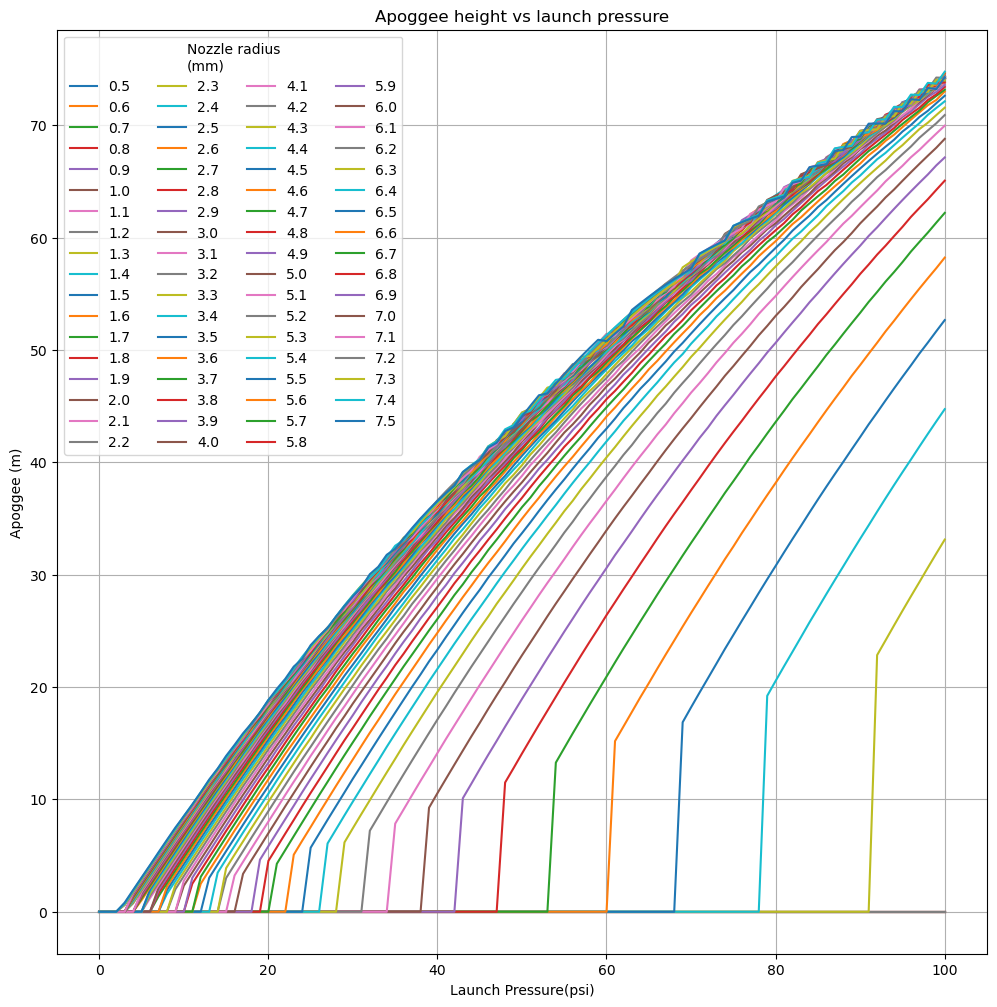

In [100]:
figsize (12,12)
fig,ax = plt.subplots(1,1)
for nozzle_r in Z_APOGGEE_DIC.keys():
    ax.plot(Z_APOGGEE_DIC[nozzle_r]['LAUNCH_PRESSURE'],Z_APOGGEE_DIC[nozzle_r]['Z_APOGGEE'],label=f'{nozzle_r:2.1f}')
ax.set_ylabel('Apoggee (m)')
ax.set_xlabel('Launch Pressure(psi)')
ax.set_title('Apoggee height vs launch pressure')
ax.legend(title='Nozzle radius\n(mm)',ncol=4)
ax.grid(visible=True)
fig.savefig('output/Apoggee_p_n_2D.png')
plt.show()

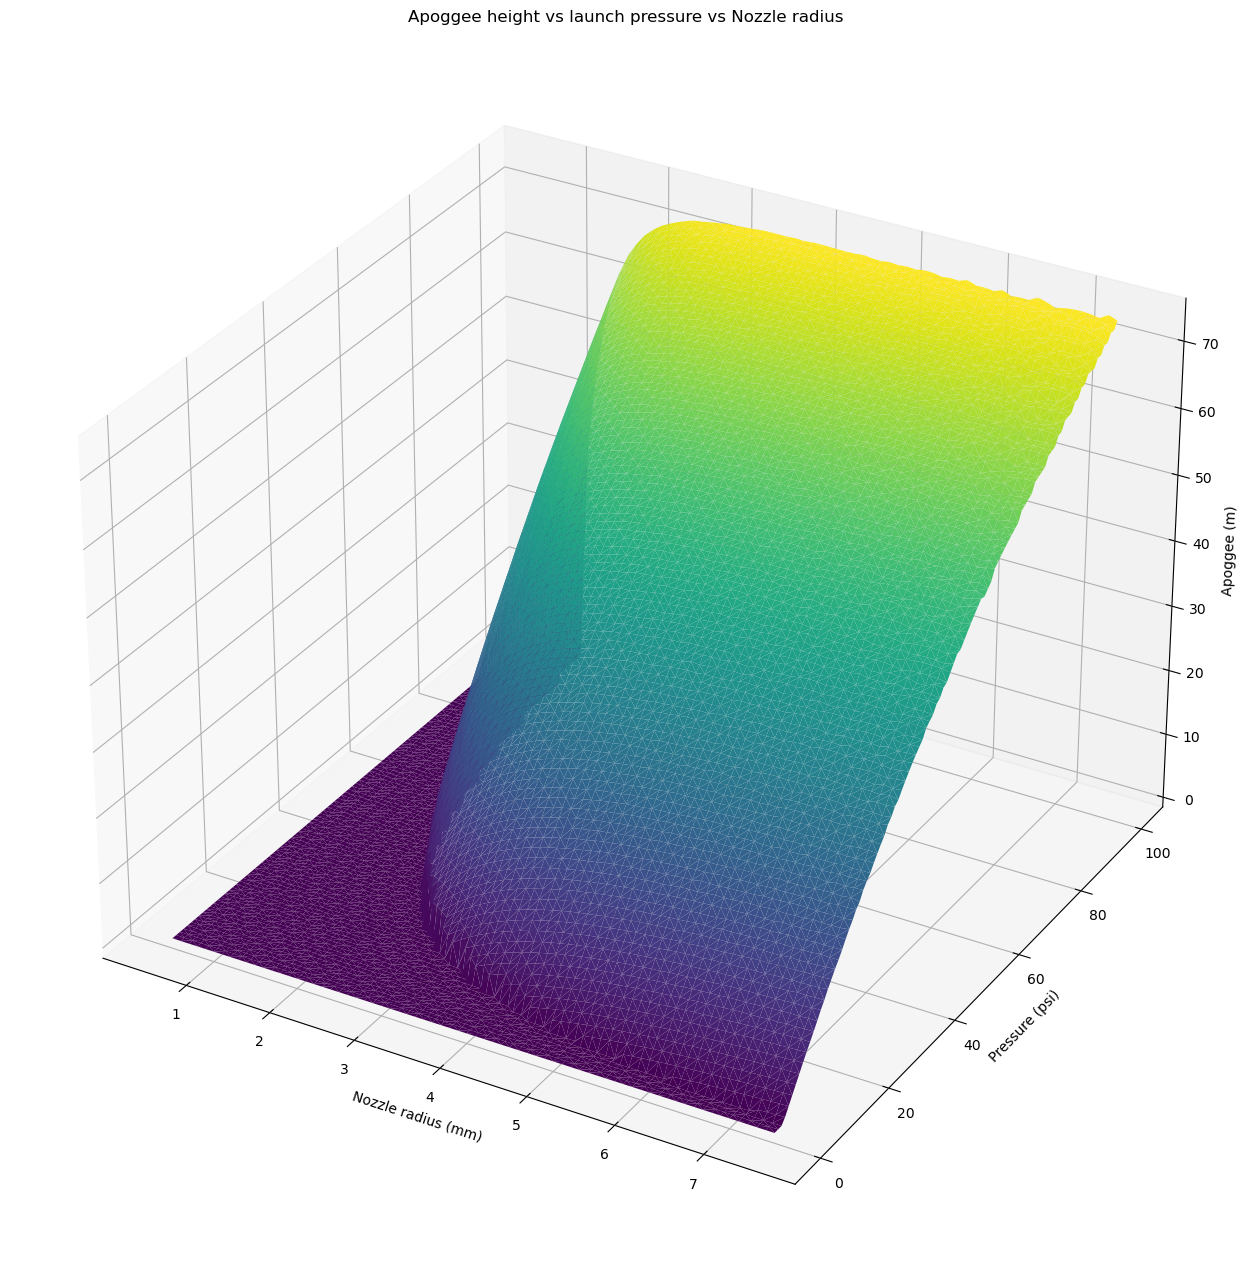

In [122]:
# 3D graph com matplotlib
figsize (16,16)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot_trisurf (R_NOZZLE_ALL,LAUNCH_PRESSURE_ALL,Z_APOGGEE_ALL,linewidth=0, antialiased=True,cmap='viridis',edgecolor='none')
ax.set_xlabel('Nozzle radius (mm)')
ax.set_ylabel('Pressure (psi)')
ax.set_zlabel('Apoggee (m)')
ax.set_title('Apoggee height vs launch pressure vs Nozzle radius')
ax.grid(visible=True)
fig.savefig('output/Apoggee_p_n_3D.png')
plt.show()


Running simulations:

Nozzle Radius: 5.0
Launch Pressure: 
   5   10   15   20   25   30   35   40   45   50   55   60   65   70   75   80   85   90   95  100 

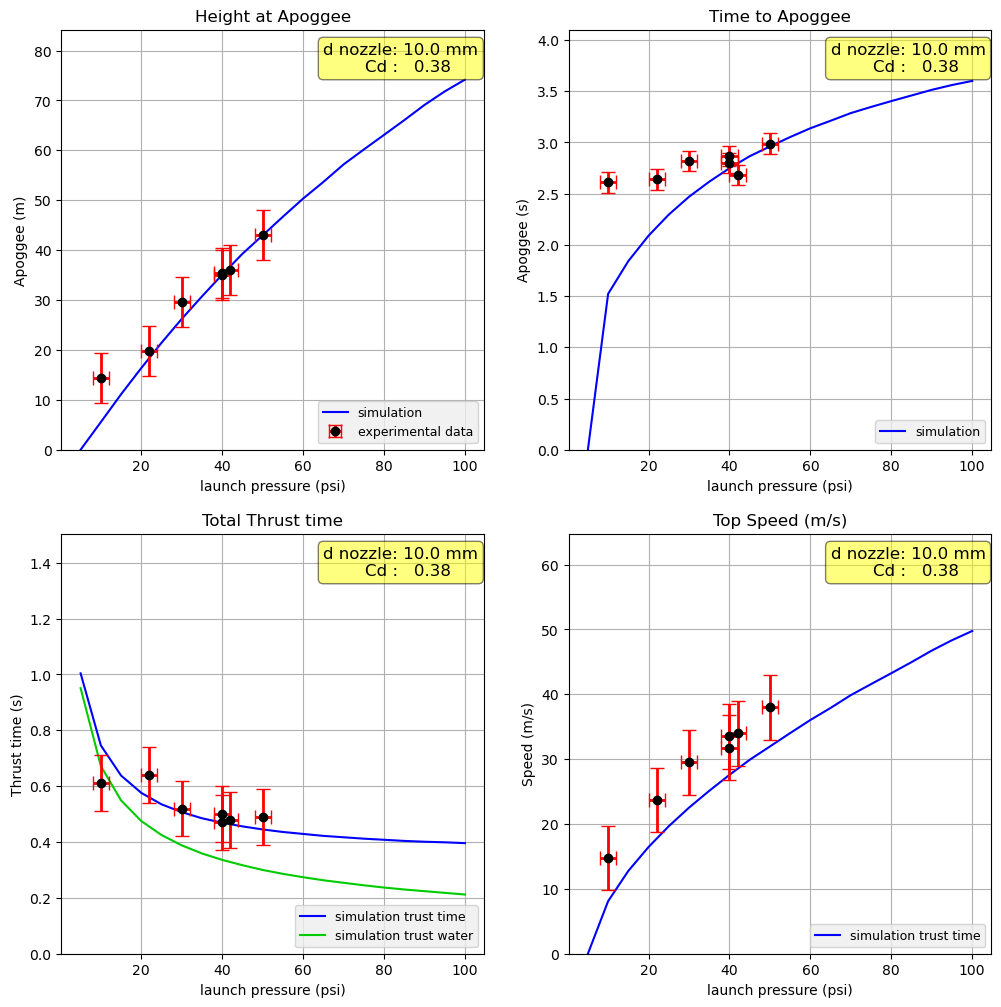

Nozzle Radius: 7.0
Launch Pressure: 
   5   10   15   20   25   30   35   40   45   50   55   60   65   70   75   80   85   90   95  100 

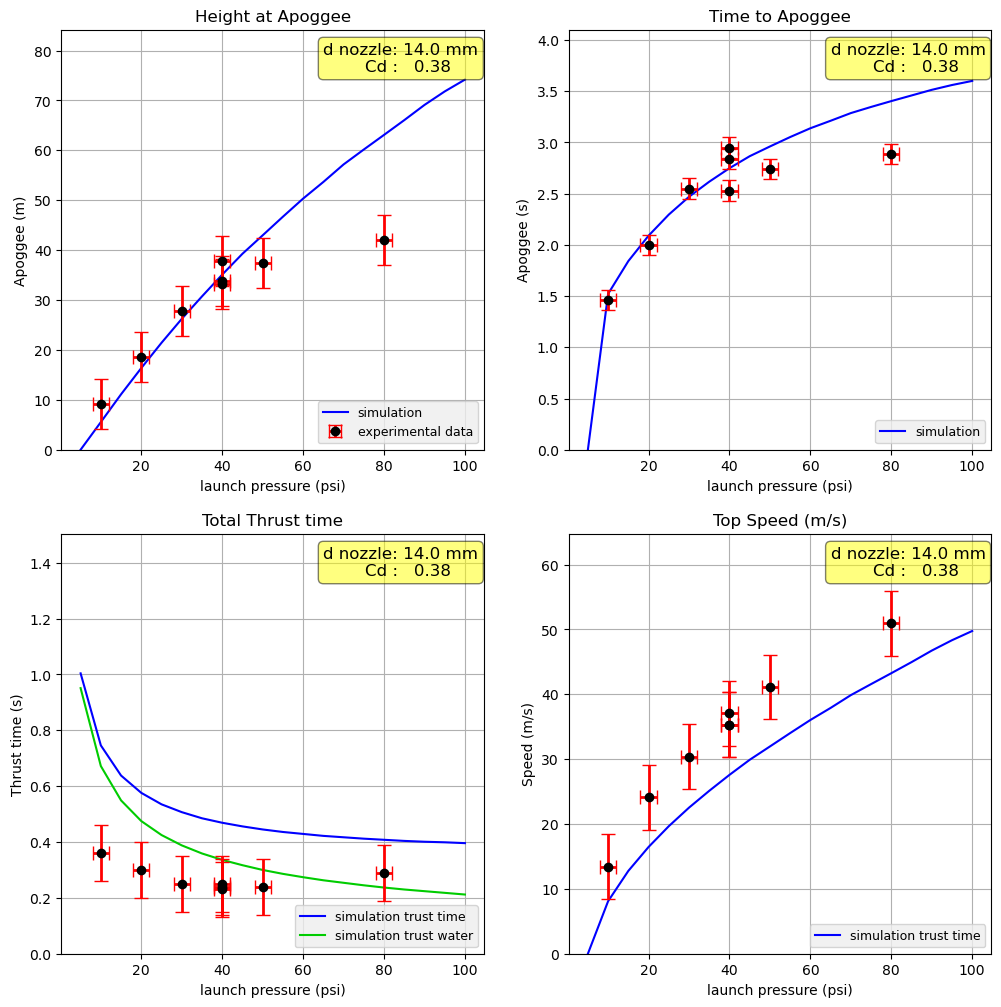


Simulation completed


In [365]:
# Plot the expected Apoggee vs pressure and experimental data

Nozzles_r = [5,7]
_Cd = 0.38

# Experimental conditions:
print ('Running simulations:\n')
for _nozzle_r in Nozzles_r: 
    print (f'Nozzle Radius: {_nozzle_r:2.1f}') 
    P_launch_data=dataSI_df[dataSI_df['Nozzle diameter(mm)']==_nozzle_r*2]['Pressure (PSI)'].to_list()    
    Z_apoggee_data=dataSI_df[dataSI_df['Nozzle diameter(mm)']==_nozzle_r*2]['z Apoggee (m)'].to_list()
    T_apoggee_data=dataSI_df[dataSI_df['Nozzle diameter(mm)']==_nozzle_r*2]['t Apoggee (s)'].to_list()
    V_max_data=dataSI_df[dataSI_df['Nozzle diameter(mm)']==_nozzle_r*2]['top speed (m/s)'].to_list()
    T_thurst_data=dataSI_df[dataSI_df['Nozzle diameter(mm)']==_nozzle_r*2]['Thurst time (s)'].to_list()
    
    # Simula o nozzle em diferentes pressões de lançamento:
    p_initial=5
    δp = 5
    _p_launch = p_initial
    P_launch_simulation = np.array([],float)
    Z_apoggee_simulation = np.array([],float)
    T_apoggee_simulation = np.array([],float)
    V_max_simulation = np.array([],float)
    T_thrust_simulation = np.array([],float)
    T_water_ends_simulation = np.array([],float)
    
    print ('Launch Pressure: ')
    while _p_launch <= 100:
        _simulation_results = integration (nozzle_r=_nozzle_r,p_launch=_p_launch,Cd=_Cd)
        print (f'{_p_launch:4.0f} ',end='')
        
        P_launch_simulation = np.append(P_launch_simulation,_p_launch)
        Z_apoggee_simulation = np.append(Z_apoggee_simulation,_simulation_results['trajectory_data']['z_apoggee'])
        T_apoggee_simulation = np.append(T_apoggee_simulation,_simulation_results['trajectory_data']['t_apoggee'])
        V_max_simulation = np.append(V_max_simulation,_simulation_results['trajectory_data']['v_max'])
        T_thrust_simulation = np.append(T_thrust_simulation,_simulation_results['trajectory_data']['t_thrust_time'])                              
        T_water_ends_simulation = np.append(T_water_ends_simulation,_simulation_results['trajectory_data']['t_water_ends'])
        _p_launch += δp      
        
    # Plota a curva teórica calculada anteriormente e sobrepõem com os pontos experimentais:        
    figsize (12,12)
    graph_textbox_low = dict(boxstyle='round', facecolor='#008000', alpha=0.5)
    graph_textbox_corner = dict(boxstyle='round', facecolor='yellow', alpha=0.5)    
    text_str = f"d nozzle: {_nozzle_r*2:2.1f} mm"+'\n'+f"        Cd :   {_Cd:1.2f}"
    fig,ax = plt.subplots(2,2)
    plot_y_max = np.zeros((2,2),float)

    plot_y_max[0,0]=np.max(Z_apoggee_simulation)+10
    ax[0,0].plot(P_launch_simulation,Z_apoggee_simulation,color='#0000FF',label='simulation')
    ax[0,0].errorbar(P_launch_data,Z_apoggee_data,xerr=uncertainty_manometer_p,yerr=uncertainty_altimeter_z,fmt='o',ecolor='red',color='black',elinewidth=2,capsize=5,label='experimental data')
    ax[0,0].set_ylim([0,plot_y_max[0,0]])
    ax[0,0].set_ylabel('Apoggee (m)')
    ax[0,0].set_xlabel('launch pressure (psi)')
    ax[0,0].set_title('Height at Apoggee')
    ax[0,0].grid(visible=True)
    ax[0,0].text(65,plot_y_max[0,0]*0.90, text_str, bbox=graph_textbox_corner, fontsize=12)  
    ax[0,0].legend(loc='lower right',fontsize=9, facecolor='#EEEEEE')

    plot_y_max[0,1]=np.max(T_apoggee_simulation)+0.5
    ax[0,1].plot(P_launch_simulation,T_apoggee_simulation,color='#0000FF',label='simulation')
    ax[0,1].errorbar(P_launch_data,T_apoggee_data,xerr=uncertainty_manometer_p,yerr=uncertainty_altimeter_t,fmt='o',ecolor='red',color='black',elinewidth=2,capsize=5)
    ax[0,1].set_ylim([0,plot_y_max[0,1]])
    ax[0,1].set_ylabel('Apoggee (s)')
    ax[0,1].set_xlabel('launch pressure (psi)')
    ax[0,1].set_title('Time to Apoggee')
    ax[0,1].grid(visible=True)
    ax[0,1].text(65,plot_y_max[0,1]*0.90, text_str, bbox=graph_textbox_corner, fontsize=12) 
    ax[0,1].legend(loc='lower right',fontsize=9, facecolor='#EEEEEE')

    plot_y_max[1,0]=np.max(T_thrust_simulation)+0.5
    ax[1,0].plot(P_launch_simulation,T_thrust_simulation,color='#0000FF',label='simulation trust time')
    ax[1,0].plot(P_launch_simulation,T_water_ends_simulation,color='#00CC00',label='simulation trust water')
    ax[1,0].errorbar(P_launch_data,T_thurst_data,xerr=uncertainty_manometer_p,yerr=uncertainty_altimeter_t,fmt='o',ecolor='red',color='black',elinewidth=2,capsize=5)
    ax[1,0].set_ylim([0,plot_y_max[1,0]])
    ax[1,0].set_ylabel('Thrust time (s)')
    ax[1,0].set_xlabel('launch pressure (psi)')
    ax[1,0].set_title('Total Thrust time')
    ax[1,0].grid(visible=True)
    ax[1,0].text(65,plot_y_max[1,0]*0.90, text_str, bbox=graph_textbox_corner, fontsize=12) 
    ax[1,0].legend(loc='lower right',fontsize=9, facecolor='#EEEEEE')

    plot_y_max[1,1]=np.max(V_max_simulation)+15
    ax[1,1].plot(P_launch_simulation,V_max_simulation,color='#0000FF',label='simulation trust time')
    ax[1,1].errorbar(P_launch_data,V_max_data,xerr=uncertainty_manometer_p,yerr=(uncertainty_altimeter_speed),fmt='o',ecolor='red',color='black',elinewidth=2,capsize=5)
    ax[1,1].set_ylim([0,plot_y_max[1,1]])
    ax[1,1].set_ylabel('Speed (m/s)')
    ax[1,1].set_xlabel('launch pressure (psi)')
    ax[1,1].set_title('Top Speed (m/s)')
    ax[1,1].grid(visible=True)
    ax[1,1].text(65,plot_y_max[1,1]*0.90, text_str, bbox=graph_textbox_corner, fontsize=12) 
    ax[1,1].legend(loc='lower right',fontsize=9, facecolor='#EEEEEE')
    
    # Save:
    _simulation_file = f'output/Simulation_vs_ExpData_Nozzle_{_nozzle_r:1.2f}mm.png'
    fig.savefig(_simulation_file)
    plt.show()
print ()
print ('Simulation completed')

    
